### Imports

In [1]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import os
import pickle
from sklearn import preprocessing as skp
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,accuracy_score
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
os.chdir('disk/ERIK_ADVANCED_PRACTICAL/')

### Load preprocessed data

In [2]:
f = open('X_full_ordered_VN_stopwords.pkl','rb')

In [3]:
X = pickle.load(f)

In [4]:
DOCUMENT_COUNT = len(X)

In [5]:
f.close()
y = np.load('y_full_ordered.npy')

In [6]:
z = list(zip(X,y))
random.shuffle(z)
mixed_X, mixed_y= zip(*z)

In [15]:
len(mixed_X)

100000

In [7]:
encoder = skp.LabelEncoder()
y_encoded = encoder.fit_transform(mixed_y)
#y_test_encoded = encoder.transform(y_test)

In [8]:
N_TOPICS = encoder.classes_.shape[0]

In [9]:
TOPICS = encoder.classes_

## Train and test models

#### Train SVM

In [16]:
N_TRAIN_SAMPLES = 85000

### Grid search on full data

In [11]:
MAX_NGRAM = 3
N_TRIALS = 5

In [17]:
def grid_search(Constructor = MultinomialNB, max_ngram = 3,min_df = 80, max_df = 0.2, n_trials = 5,n_train_samples = 110000):
    MIN_DF = 160 # upper bound for the min_df
    MAX_DF = 0.03 # lower bound for the max_df
    min_dfs = np.linspace(min_df,MIN_DF,num = n_trials)
    max_dfs = np.linspace(max_df,MAX_DF,num = n_trials)
    def create_params(max_ngram):
        parameters = []       
        for i in range(1,max_ngram+1):
            for min_ in min_dfs:                
                for max_ in max_dfs:
                    parameters.append({'max_df':max_,'min_df':int(min_),'ngram_range':(1,i)})
        return parameters
                
    parameters = create_params(max_ngram)
    matrices = []
    precisions = []
    recalls = []
    f1s = []
    for params in parameters:
        print('\n\n params: {} \n'.format(params))
        tfidf_vectorizer = TfidfVectorizer(token_pattern= '(\S+)',**params)
        tfidf_vectorizer.fit(mixed_X[:n_train_samples])
        
        print('NUMBER OF FEATURES:',len(tfidf_vectorizer.get_feature_names()))
        X_train_tfidf = tfidf_vectorizer.transform(mixed_X[:n_train_samples])
        if Constructor==SVC:
            model = Constructor(C = 1.0, kernel = 'linear',max_iter = 250,gamma='scale', decision_function_shape='ovr')
        else:
            model = Constructor()
        model.fit(X_train_tfidf,y_encoded[:n_train_samples])
        X_test_tfidf = tfidf_vectorizer.transform(mixed_X[n_train_samples:])
        predictions = model.predict(X_test_tfidf)
        confusion_matrix_ = confusion_matrix(y_encoded[n_train_samples:],predictions)
        accuracy = accuracy_score(y_encoded[n_train_samples:],predictions)
        print('accuracy: ',accuracy)
        print('confusion matrix : \n',confusion_matrix_)
        precision = precision_score(y_encoded[n_train_samples:],predictions,average = None)
        print('\nprecision: ',precision)
        average_precision = precision_score(y_encoded[n_train_samples:],predictions,average = 'macro')
        print('global precision: ',average_precision)
        precisions.append([precision,average_precision])
        recall = recall_score(y_encoded[n_train_samples:],predictions,average = None)
        print('\nrecall: ',recall)
        average_recall = recall_score(y_encoded[n_train_samples:],predictions,average = 'macro')
        print('average recall',average_recall)
        recalls.append([recall,average_recall])
        matrices.append([confusion_matrix_,accuracy])
        f1 = f1_score(y_encoded[n_train_samples:],predictions,average = None)
        print('f1: \n',f1)
        average_f1 = f1_score(y_encoded[n_train_samples:],predictions,average = 'macro')
        print('average f1: ',average_f1)
        f1s.append([f1,average_f1])
    return parameters, matrices, precisions, recalls, f1s

Because of the time complexity of the svm algorithm train linear svm only on tf-idf parameteres that have yielded the highes f1 score with naive bayes

In [20]:
parameters, matrices, precisions, recalls, f1s = grid_search(max_ngram = MAX_NGRAM,min_df = 80, max_df = 0.2, n_trials = N_TRIALS,n_train_samples=N_TRAIN_SAMPLES)



 params: {'max_df': 0.2, 'min_df': 80, 'ngram_range': (1, 1)} 

NUMBER OF FEATURES: 4667
accuracy:  0.7758666666666667
confusion matrix : 
 [[1287    1    7    7    3   25   94   40   25   42]
 [   4 1387   17    0   20    5   16   31    7   11]
 [  12  104 1179    3   17   42  100   42   46    8]
 [   3   19    5 1162   47   17    3   13   40  173]
 [   2   33   14   11 1238    8    8   16    9   61]
 [  39   11   53   45   36 1018   82   54  116   58]
 [  95   74  109    5   19   26 1084   49   34   16]
 [  29   70   38   24   35   24   42 1179   12   51]
 [  13   17   13   51   19   61   21   26 1267   50]
 [  79   53   32  269   88   30   31   24   28  837]]

precision:  [0.82341651 0.78405879 0.80368098 0.73684211 0.81340342 0.81050955
 0.73193788 0.79986431 0.79987374 0.64039786]
global precision:  0.774398514421411

recall:  [0.84062704 0.9259012  0.75917579 0.78407557 0.88428571 0.67328042
 0.71740569 0.78390957 0.82379714 0.56900068]
average recall 0.7761458827677437
f1: 
 [

NUMBER OF FEATURES: 4003
accuracy:  0.7712
confusion matrix : 
 [[1267    2    8    8    4   28   92   43   32   47]
 [   3 1386   18    0   21    5   15   32    7   11]
 [  10  104 1174    4   17   44  104   40   49    7]
 [   2   18    4 1159   50   17    3   12   41  176]
 [   2   33   14   13 1232   12    8   15   11   60]
 [  47   10   49   47   39 1016   79   55  112   58]
 [  99   72  110    5   19   25 1084   46   37   14]
 [  29   69   40   21   34   28   45 1170   14   54]
 [  14   19   12   49   19   61   22   26 1265   51]
 [  81   53   35  267   94   30   34   27   35  815]]

precision:  [0.81531532 0.78482446 0.80191257 0.73680865 0.8057554  0.80252765
 0.7294751  0.79809004 0.78914535 0.63031709]
global precision:  0.7694171619763011

recall:  [0.82756368 0.92523364 0.75595621 0.78205128 0.88       0.67195767
 0.71740569 0.77792553 0.82249675 0.55404487]
average recall 0.771463533648699
f1: 
 [0.82139384 0.84926471 0.77825655 0.75875614 0.84124274 0.73146148
 0.72339006 

NUMBER OF FEATURES: 3206
accuracy:  0.7698666666666667
confusion matrix : 
 [[1295    1    5    7    3   27   82   41   29   41]
 [   4 1388   17    0   19    6   17   31    6   10]
 [  13  105 1170    4   16   46  108   37   48    6]
 [   3   19    4 1165   44   17    3   15   39  173]
 [   2   33   15   11 1227   11    9   17    7   68]
 [  34   10   55   49   40 1005   81   58  123   57]
 [ 104   70  114    6   21   28 1060   54   35   19]
 [  24   72   49   25   36   30   47 1149   13   59]
 [  13   19   13   50   19   64   22   26 1261   51]
 [  81   53   32  269   91   30   30   23   34  828]]

precision:  [0.82326764 0.78418079 0.79375848 0.73455233 0.80936675 0.79509494
 0.72652502 0.79186768 0.79059561 0.63109756]
global precision:  0.7680306803834538

recall:  [0.84585238 0.92656876 0.75338055 0.78609987 0.87642857 0.66468254
 0.70152217 0.76396277 0.81989597 0.56288239]
average recall 0.7701275970758322
f1: 
 [0.83440722 0.8494492  0.77304262 0.75945241 0.84156379 0.7240634


NUMBER OF FEATURES: 2739
accuracy:  0.741
confusion matrix : 
 [[1218    3   13   14   14   31  102   44   40   52]
 [   6 1315   33    6   33    8   19   44   12   22]
 [  13  108 1110    7   22   59  112   54   56   12]
 [   5   25    8 1135   63   14    3   15   38  176]
 [   7   44   28   20 1151   17   13   20   13   87]
 [  39   15   51   56   50 1002   68   54  118   59]
 [ 103   72  110    8   26   32 1039   55   41   25]
 [  31   68   47   23   37   37   54 1132   13   62]
 [  15   18   14   62   26   69   21   21 1233   59]
 [  76   66   34  263  101   42   38   27   44  780]]

precision:  [0.80502313 0.75836217 0.76657459 0.71204517 0.75574524 0.76430206
 0.70728387 0.77216917 0.76679104 0.58470765]
global precision:  0.7393004080753586

recall:  [0.79555846 0.87783712 0.71474565 0.76585695 0.82214286 0.66269841
 0.68762409 0.75265957 0.80169051 0.53025153]
average recall 0.7411065149359757
f1: 
 [0.80026281 0.81373762 0.73975342 0.73797139 0.78754704 0.7098831
 0.69731544 0

NUMBER OF FEATURES: 4508
accuracy:  0.773
confusion matrix : 
 [[1287    1    7    7    3   28   86   40   26   46]
 [   3 1387   20    0   17    6   18   31    6   10]
 [  13  103 1172    4   16   48  104   39   47    7]
 [   4   18    3 1163   47   18    3   13   40  173]
 [   1   33   17   12 1231   10   11   17    9   59]
 [  33   11   51   48   35 1014   86   56  117   61]
 [ 100   69  111    5   21   28 1075   49   35   18]
 [  26   69   43   21   35   28   42 1170   13   57]
 [  13   14   15   54   17   58   24   26 1266   51]
 [  80   51   32  268   90   31   30   26   33  830]]

precision:  [0.825      0.78986333 0.79673691 0.73514539 0.81415344 0.79905437
 0.72684246 0.79754601 0.79522613 0.63262195]
global precision:  0.7712189992933352

recall:  [0.84062704 0.9259012  0.75466838 0.78475034 0.87928571 0.67063492
 0.71144937 0.77792553 0.82314694 0.56424201]
average recall 0.7732631458339597
f1: 
 [0.83274021 0.85248924 0.77513228 0.75913838 0.84546703 0.72923409
 0.71906355 

NUMBER OF FEATURES: 3451
accuracy:  0.7704666666666666
confusion matrix : 
 [[1290    1    7    7    3   29   86   41   26   41]
 [   3 1386   19    1   18    6   18   31    6   10]
 [  15  100 1173    6   15   46  107   36   49    6]
 [   4   18    4 1163   45   18    3   15   38  174]
 [   1   32   17   12 1222   12   11   17    9   67]
 [  36   10   53   50   38 1011   82   59  119   54]
 [ 103   70  107    6   22   28 1065   55   36   19]
 [  25   69   51   23   35   32   43 1152   13   61]
 [  13   16   12   51   18   62   22   26 1268   50]
 [  81   52   33  271   88   32   28   23   36  827]]

precision:  [0.82113304 0.79019384 0.79471545 0.73144654 0.8125     0.79231975
 0.72696246 0.79175258 0.7925     0.63177998]
global precision:  0.7685303635557913

recall:  [0.84258654 0.92523364 0.7553123  0.78475034 0.87285714 0.66865079
 0.70483124 0.76595745 0.82444733 0.56220258]
average recall 0.7706829364144678
f1: 
 [0.83172147 0.85239852 0.77451304 0.75716146 0.8415978  0.72525108

NUMBER OF FEATURES: 3081
accuracy:  0.7633333333333333
confusion matrix : 
 [[1253    2   10    9    5   32   95   42   35   48]
 [   3 1378   19    0   21    5   16   35    6   15]
 [  13   98 1171    5   16   48  100   42   52    8]
 [   3   19    5 1159   40   20    3   15   39  179]
 [   2   34   15   13 1215   10   13   17   12   69]
 [  38   12   50   48   45 1005   82   59  118   55]
 [  97   68  109    7   24   30 1059   55   40   22]
 [  29   70   48   20   36   35   46 1148   12   60]
 [  14   19   13   51   21   63   26   25 1255   51]
 [  80   52   36  270   96   33   30   24   43  807]]

precision:  [0.81788512 0.78652968 0.79336043 0.73261694 0.79986833 0.78454333
 0.72040816 0.78522572 0.77853598 0.61415525]
global precision:  0.7613128944752122

recall:  [0.81841933 0.91989319 0.75402447 0.78205128 0.86785714 0.66468254
 0.70086036 0.76329787 0.8159948  0.54860639]
average recall 0.7635687376421011
f1: 
 [0.81815214 0.848      0.77319247 0.75652742 0.83247688 0.71965628

NUMBER OF FEATURES: 4527
accuracy:  0.7726666666666666
confusion matrix : 
 [[1286    1    7    7    3   27   88   40   26   46]
 [   3 1386   20    0   17    6   18   32    6   10]
 [  13  103 1172    4   16   48  104   39   47    7]
 [   4   18    3 1163   47   18    3   13   40  173]
 [   1   33   17   12 1230   10   11   17   10   59]
 [  33   11   51   48   35 1013   86   59  115   61]
 [ 100   69  111    5   21   28 1075   49   35   18]
 [  27   69   43   22   35   28   42 1167   13   58]
 [  13   14   15   52   17   59   24   26 1267   51]
 [  80   51   32  268   89   31   30   26   33  831]]

precision:  [0.82435897 0.78974359 0.79673691 0.73561037 0.81456954 0.7988959
 0.7258609  0.79495913 0.79585427 0.63242009]
global precision:  0.7709009681966176

recall:  [0.83997387 0.92523364 0.75466838 0.78475034 0.87857143 0.66997354
 0.71144937 0.77593085 0.82379714 0.56492182]
average recall 0.7729270396218222
f1: 
 [0.83209317 0.85213649 0.77513228 0.75938622 0.84536082 0.72877698


NUMBER OF FEATURES: 3707
accuracy:  0.7516
confusion matrix : 
 [[1236    3   10   11    9   30   97   46   37   52]
 [   6 1323   32    4   33    6   20   44   11   19]
 [  16  102 1135    5   21   53  109   50   51   11]
 [   3   22    5 1136   70   17    3   14   34  178]
 [   4   39   24   18 1176   16   12   18   16   77]
 [  34   13   53   56   44 1016   73   54  114   55]
 [ 102   71  105    6   27   28 1062   48   41   21]
 [  32   71   45   20   33   33   47 1159   10   54]
 [  17   20   11   53   23   71   21   23 1243   56]
 [  81   66   34  262   94   39   39   28   40  788]]

precision:  [0.80731548 0.76473988 0.78060523 0.7231063  0.76862745 0.77616501
 0.71611598 0.7809973  0.77833438 0.60106789]
global precision:  0.749707490535716

recall:  [0.80731548 0.88317757 0.73084353 0.76653171 0.84       0.67195767
 0.7028458  0.7706117  0.80819246 0.53569001]
average recall 0.7517165928832048
f1: 
 [0.80731548 0.8197026  0.75490522 0.74418605 0.80273038 0.72031195
 0.70941884 

NUMBER OF FEATURES: 3110
accuracy:  0.7664666666666666
confusion matrix : 
 [[1283    1    7    7    3   28   90   41   31   40]
 [   3 1378   18    1   21    5   17   36    6   13]
 [  13   98 1174    4   17   48  104   39   50    6]
 [   4   19    5 1161   42   18    3   16   40  174]
 [   1   32   17   13 1219   10   14   16   10   68]
 [  31   12   51   50   41 1010   81   60  121   55]
 [ 100   68  109    7   25   30 1056   53   39   24]
 [  28   70   53   23   33   35   46 1141   12   63]
 [  14   19   13   54   20   62   25   24 1255   52]
 [  81   52   33  270   92   36   27   23   37  820]]

precision:  [0.82349166 0.78787879 0.79324324 0.73018868 0.80568407 0.78783151
 0.72180451 0.78743961 0.78388507 0.62357414]
global precision:  0.7645021292099962

recall:  [0.83801437 0.91989319 0.75595621 0.78340081 0.87071429 0.66798942
 0.69887492 0.75864362 0.8159948  0.55744392]
average recall 0.7666925536252064
f1: 
 [0.83068954 0.84878349 0.77415101 0.75585938 0.83693786 0.72297781

##### Save results of Naive Bayes

In [21]:
np_recalls = np.array(recalls)

np_f1 = np.array(f1s)

np_precisions = np.array(precisions)

np_accuracy = np.array(matrices)

np.save('accuracies_1_partialDS.npy',np_accuracy)
np.save('f1_1_partialDS.npy',np_f1)
np.save('precisions_1_partialDS.npy',np_precisions)
np.save('recalls_1_partialDS.npy',np_recalls)
with open('parameters_1_partialDS','wb')as f:
    pickle.dump(parameters,f)

##### Load results

In [22]:
np_recalls = np.load('recalls_1_partialDS.npy',allow_pickle=True)
np_accuracy = np.load('accuracies_1_partialDS.npy',allow_pickle=True)
np_precisions = np.load('precisions_1_partialDS.npy',allow_pickle=True)
np_f1 = np.load('f1_1_partialDS.npy',allow_pickle=True)
f = open('parameters_1_partialDS','rb')
parameters = pickle.load(f)

In [23]:
max_1gram_f1 = np.argmax(np_f1[:N_TRIALS**2,1])
max_1gram_prec = np.argmax(np_precisions[:N_TRIALS**2,1])
max_1gram_recall = np.argmax(np_recalls[:N_TRIALS**2,1])
max_1gram_acc = np.argmax(np_accuracy[:N_TRIALS**2,1])

In [24]:
max_2gram_f1 = np.argmax(np_f1[N_TRIALS**2:(N_TRIALS**2)*2,1])
max_2gram_prec = np.argmax(np_precisions[N_TRIALS**2:(N_TRIALS**2)*2,1])
max_2gram_recall = np.argmax(np_recalls[N_TRIALS**2:(N_TRIALS**2)*2,1])
max_2gram_acc = np.argmax(np_accuracy[N_TRIALS**2:(N_TRIALS**2)*2,1])

In [25]:
max_3gram_f1 = np.argmax(np_f1[(N_TRIALS**2)*2:,1])
max_3gram_prec = np.argmax(np_precisions[(N_TRIALS**2)*2:,1])
max_3gram_recall = np.argmax(np_recalls[(N_TRIALS**2)*2:,1])
max_3gram_acc = np.argmax(np_accuracy[(N_TRIALS**2)*2:,1])

In [26]:
GLOBAL_MAX_F1 = np.argmax(np_f1[:,1])
GLOBAL_MAX_PREC = np.argmax(np_precisions[:,1])
GLOBAL_MAX_RECALL = np.argmax(np_recalls[:,1])
GLOBAL_MAX_ACC = np.argmax(np_accuracy[:,1],axis =0)

In [27]:
params_svm = parameters[GLOBAL_MAX_F1]

In [28]:
svm_parameters, svm_matrices, svm_precisions, svm_recalls, svm_f1s= grid_search(Constructor = SVC,
                                                                                max_ngram = 3,
                                                                                min_df = params_svm['min_df'],
                                                                                max_df = params_svm['max_df'],
                                                                                n_trials = 1,
                                                                                n_train_samples = N_TRAIN_SAMPLES)



 params: {'max_df': 0.115, 'min_df': 80, 'ngram_range': (1, 1)} 

NUMBER OF FEATURES: 4665


/home/ek/.local/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


accuracy:  0.6777333333333333
confusion matrix : 
 [[1241    3   15    7   10   39  104   32   22   58]
 [   9 1312   46    8   26    7   20   54    9    7]
 [  27   83 1164   17   21   54  125   25   27   10]
 [  23   19   17 1036   28   43    6   17   49  244]
 [  10   33   17   72 1176   13   17    8    8   46]
 [  75   35  118   92   29  865   62   50  151   35]
 [ 205   53  212   25   37  119  778   41   25   16]
 [  76   72   68   62   39   57   74 1010   20   26]
 [  36   24   44   95   23  141   29   36 1091   19]
 [ 132   57   49  447  105   74   36   30   48  493]]

precision:  [0.67666303 0.77587226 0.66514286 0.55668995 0.78714859 0.61260623
 0.62190248 0.77513431 0.75241379 0.51677149]
global precision:  0.6740344997050345

recall:  [0.81058132 0.87583445 0.74951706 0.69905533 0.84       0.57208995
 0.5148908  0.67154255 0.70936281 0.33514616]
average recall 0.6778020428702577
f1: 
 [0.73759287 0.82282847 0.70481381 0.61980257 0.81271596 0.59165527
 0.56335988 0.7196295  0

##### Save results for SVC

In [29]:
np_recalls_svm = np.array(svm_recalls)

np_f1_svm = np.array(svm_f1s)

np_precisions_svm = np.array(svm_precisions)

np_accuracy_svm = np.array(svm_matrices)

np.save('accuracies_svm_partialDS.npy',np_accuracy_svm)
np.save('f1_svm_partialDS.npy',np_f1_svm)
np.save('precisions_svm_partialDS.npy',np_precisions_svm)
np.save('recalls_svm_partialDS.npy',np_recalls_svm)
with open('parameters_svm_partialDS','wb')as f:
    pickle.dump(svm_parameters,f)

##### Load SVM results

In [30]:
np_recalls_svm = np.load('recalls_svm_partialDS.npy',allow_pickle=True)
np_accuracy_svm = np.load('accuracies_svm_partialDS.npy',allow_pickle=True)
np_precisions_svm = np.load('precisions_svm_partialDS.npy',allow_pickle=True)
np_f1_svm = np.load('f1_svm_partialDS.npy',allow_pickle=True)
f = open('parameters_svm_partialDS','rb')
svm_parameters = pickle.load(f)

In [31]:
GLOBAL_MAX_F1_SVM = np.argmax(np_f1_svm[:,1])
GLOBAL_MAX_PREC_SVM = np.argmax(np_precisions_svm[:,1])
GLOBAL_MAX_RECALL_SVM = np.argmax(np_recalls_svm[:,1])
GLOBAL_MAX_ACC_SVM = np.argmax(np_accuracy_svm[:,1],axis =0)

In [32]:
plot_parameters = list(map(lambda x: str(list(map(lambda x: round(x,4),list(x.values())[:-1])))[1:-1],parameters))

### Plot results

In [39]:
def plot_basic(ax1,title,parameters_, from_=0, to_=len(parameters),legend = ['accuracy','precision','recall','f1-score']):
    ax1.set_title(title,fontsize = 30,weight='bold')
    ax1.set_xticks(range(0,len(parameters_[from_:to_])))
    
    ax1.set_xticklabels(parameters_, rotation= 60,fontsize = 20) # return only min_df and max_df without the []

    ax1.plot(np_accuracy[from_:to_,1],'bo',markersize = 12)
    ax1.plot(np_precisions[from_:to_,1],'c*',markersize = 12)
    ax1.plot(np_recalls[from_:to_,1],'k^',markersize = 12)
    ax1.plot(np_f1[from_:to_,1],'m')

    legend_elements = [Line2D([0], [0], color = 'w',markerfacecolor='b',marker = 'o', lw=4, label='NB accuracy',markersize=25),
                       Line2D([0], [0], color = 'w',marker='*', markerfacecolor='c', label='NB precision',markersize=25),
                      Line2D([0], [0], color = 'w',marker='^', markerfacecolor='k', label='NB recall',markersize=25),
                      Line2D([0], [0], color='m', label='NB f1-score'),
                      Line2D([0], [0],color = 'w', marker='*', markerfacecolor='g', label='SVM precision',markersize=25),
                      Line2D([0], [0], color = 'w',marker='^', markerfacecolor='g', label='SVM recall',markersize=25),
                      Line2D([0], [0], color = 'w',marker='o', markerfacecolor='g', label='SVM accuracy',markersize=15),
                      Line2D([0], [0],color = 'w', marker='D', markerfacecolor='g', label='SVM f1-score',markersize=15)]
    ax1.legend(handles = legend_elements,bbox_to_anchor=(1.05, 1.01),prop={'size':20})

In [40]:
def draw_text_boxes(ax1):
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    for i in range(1,MAX_NGRAM+1):
        x_position = 0.15+(i-1)*0.3
        ax1.text(x_position, 0.6, str(i)+'-Gram', transform=ax1.transAxes, fontsize=40,weight = 'bold',
            verticalalignment='top', bbox=props)

In [54]:
def draw_max(ax1, max_list, np_f1, np_precisions, np_recalls, np_accuracy,text = 'global', third_plot = False):
    metrics_list = [np_f1, np_precisions, np_recalls, np_accuracy]
    names_list = ['max f1','max precision','max recall','max accuracy']
    ax1.plot(max_list,
             [np_f1[max_list[0],1],np_precisions[max_list[1],1],np_recalls[max_list[2],1],np_accuracy[max_list[3],1]],
             'r*',markersize = 20)
    
    for i in range(len(names_list)):
        text_y = metrics_list[i][max_list[i],1]+0.012
        text_x = max_list[i]+1
        if (i==1):
            text_x = max_list[i]+7
        if  (i==3):
            text_y = metrics_list[i][max_list[i],1]-0.027
            text_x = max_list[i]-5
        if  (i==2):
            text_x = max_list[i]-5
        ax1.annotate(text+"\n"+names_list[i]+"\n"
                    +str(round(metrics_list[i][max_list[i],1],4)),
                    xy=(max_list[i],metrics_list[i][max_list[i],1]),
                    xycoords='data',
                    xytext=(text_x,text_y),
                    textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3"),
                     fontsize = 20
                    )

In [66]:
def plot_svm(ax1, GLOBAL_MAX_F1, np_recalls_svm, np_f1_svm,
            np_precisions_svm,
            np_accuracy_svm,
            flags=[True,True,True],separate_plots = False):
    # +n because for choosing the parameters for svm we used the
    # global_max which is related to one n-gram and used the parameters
    # which were used when training NB on tf-idf up to that n-gram
    const_trials = 1 # to use in order to change the direction of the increment
    const_i = 1
    
    if GLOBAL_MAX_F1>=N_TRIALS**2:
        if GLOBAL_MAX_F1>=(N_TRIALS**2)*2:
            N = -N_TRIALS**2
            i = 2
            const_i=-1
            second = 2
        else:
            N = -N_TRIALS**2
            i = 1
            const_trials = -1
            second = 1
    else:
        N = N_TRIALS**2
        i = 0
        second = 2
    if separate_plots:
        N=0
    if flags[0]:
        ax1.text(GLOBAL_MAX_F1-3,np_recalls_svm[i,1]+0.005,
                 'svm recall: '+str(round(np_recalls_svm[i,1],4)),fontsize = 20)
        ax1.plot(GLOBAL_MAX_F1,np_recalls_svm[i,1],'g^',markersize = 15)
        
        ax1.text(GLOBAL_MAX_F1-3,np_f1_svm[i,1]+0.005,
                 'svm f1 score: '+str(round(np_f1_svm[i,1],4)),fontsize = 20)
        ax1.plot(GLOBAL_MAX_F1,np_f1_svm[i,1],'gD',markersize = 15)
        
        ax1.text(GLOBAL_MAX_F1-3,np_precisions_svm[i,1]+0.005,
                 'svm precision: '+str(round(np_precisions_svm[i,1],4)),fontsize = 20)
        ax1.plot(GLOBAL_MAX_F1,np_precisions_svm[i,1],'g*',markersize = 15)
        
        ax1.text(GLOBAL_MAX_F1-3,np_accuracy_svm[i,1]+0.009,
                 'svm accuracy: \n'+str(round(np_accuracy_svm[i,1],4)),fontsize = 20)
        ax1.plot(GLOBAL_MAX_F1,np_accuracy_svm[i,1],'go',markersize = 15)
    
    # decrease if global max is in 2 gram or 3 gram
    # increase if global max is in 1 gram
    if flags[1]:
        ax1.text(GLOBAL_MAX_F1+N-3,np_recalls_svm[i+const_i*const_trials,1]+0.005,
                 'svm recall: '+str(round(np_recalls_svm[i+const_i*const_trials,1],4)),fontsize = 20)
        ax1.plot(GLOBAL_MAX_F1+N,np_recalls_svm[i+const_i*const_trials,1],'g^',markersize = 15)
        
        ax1.text(GLOBAL_MAX_F1+N-3,np_f1_svm[i+const_i*const_trials,1]+0.005,
                 'svm f1 score: '+str(round(np_f1_svm[i+const_i*const_trials,1],4)),fontsize = 20)        
        ax1.plot(GLOBAL_MAX_F1+N,np_f1_svm[i+const_i*const_trials,1],'gD',markersize = 15)
        
        ax1.text(GLOBAL_MAX_F1+N-3,np_precisions_svm[i+const_i*const_trials,1]+0.005,
                 'svm precision: '+str(round(np_precisions_svm[i+const_i*const_trials,1],4)),fontsize = 20)        
        ax1.plot(GLOBAL_MAX_F1+N,np_precisions_svm[i+const_i*const_trials,1],'g*',markersize = 15)
        
        ax1.text(GLOBAL_MAX_F1+N-3,np_accuracy_svm[i+const_i*const_trials,1]+0.009,
                 'svm accuracy: \n'+str(round(np_accuracy_svm[i+const_i*const_trials,1],4)),fontsize = 20)        
        ax1.plot(GLOBAL_MAX_F1+N,np_accuracy_svm[i+const_i*const_trials,1],'go',markersize = 15)

    # decrease/increase by 2*N_TRIALS**2 if global max is in 3 or 1 gram
    # increase by N_TRIALS**2 if global max is in 2 gram
    if flags[2]:
        ax1.text(GLOBAL_MAX_F1+N*second*const_trials-3,np_recalls_svm[i+const_i*second,1]+0.005,
                 'svm recall: '+str(round(np_recalls_svm[i+const_i*second,1],4)),fontsize = 20)        
        ax1.plot(GLOBAL_MAX_F1+N*second*const_trials,np_recalls_svm[i+const_i*second,1],'g^',markersize = 15)
        
        ax1.text(GLOBAL_MAX_F1+N*second*const_trials-3,np_f1_svm[i+const_i*second,1]+0.005,
                 'svm f1 score: '+str(round(np_f1_svm[i+const_i*second,1],4)),fontsize = 20)         
        ax1.plot(GLOBAL_MAX_F1+N*second*const_trials,np_f1_svm[i+const_i*second,1],'gD',markersize = 15)
        
        ax1.text(GLOBAL_MAX_F1+N*second*const_trials-3,np_precisions_svm[i+const_i*second,1]+0.005,
                 'svm precision: '+str(round(np_precisions_svm[i+const_i*second,1],4)),fontsize = 20) 
        ax1.plot(GLOBAL_MAX_F1+N*second*const_trials,np_precisions_svm[i+const_i*second,1],'g*',markersize = 15)
        
        ax1.text(GLOBAL_MAX_F1+N*second*const_trials-3,np_accuracy_svm[i+const_i*second,1]+0.009,
                 'svm accuracy: \n'+str(round(np_accuracy_svm[i+const_i*second,1],4)),fontsize = 20) 
        ax1.plot(GLOBAL_MAX_F1+N*second*const_trials,np_accuracy_svm[i+const_i*second,1],'go',markersize = 15)
    

In [73]:
def plot_confusion_matrix(ax, confusion_matrix_,title,cmap = plt.cm.Blues):
    img = ax.imshow(confusion_matrix_,cmap) # multiply in order to accentuate the differences between the 0s and everything else
    #ax.figure.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
    ax.set(xticks=np.arange(confusion_matrix_.shape[1]),
               yticks=np.arange(confusion_matrix_.shape[0]),
               # ... and label them with the respective list entries
          )
    ax.set_xticklabels(encoder.classes_,fontsize = 25)
    ax.set_yticklabels(encoder.classes_,fontsize = 25)
    ax.set_ylabel('True Classes', fontsize = 20, weight = 'bold')
    ax.set_xlabel('Predictions', fontsize = 20, weight = 'bold')
    ax.set_title(title, fontsize = 25, weight = 'bold')
        # Rotate the tick labels and set their alignment.
    _=plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    fmt = 'd'
    thresh = confusion_matrix_.max() / 2.
    for i in range(confusion_matrix_.shape[0]):
        for j in range(confusion_matrix_.shape[1]):
            ax.text(j, i, format(confusion_matrix_[i, j], fmt),
                    ha="center", va="center",
                    color="white" if confusion_matrix_[i, j] > thresh else "black")
    fig.tight_layout()

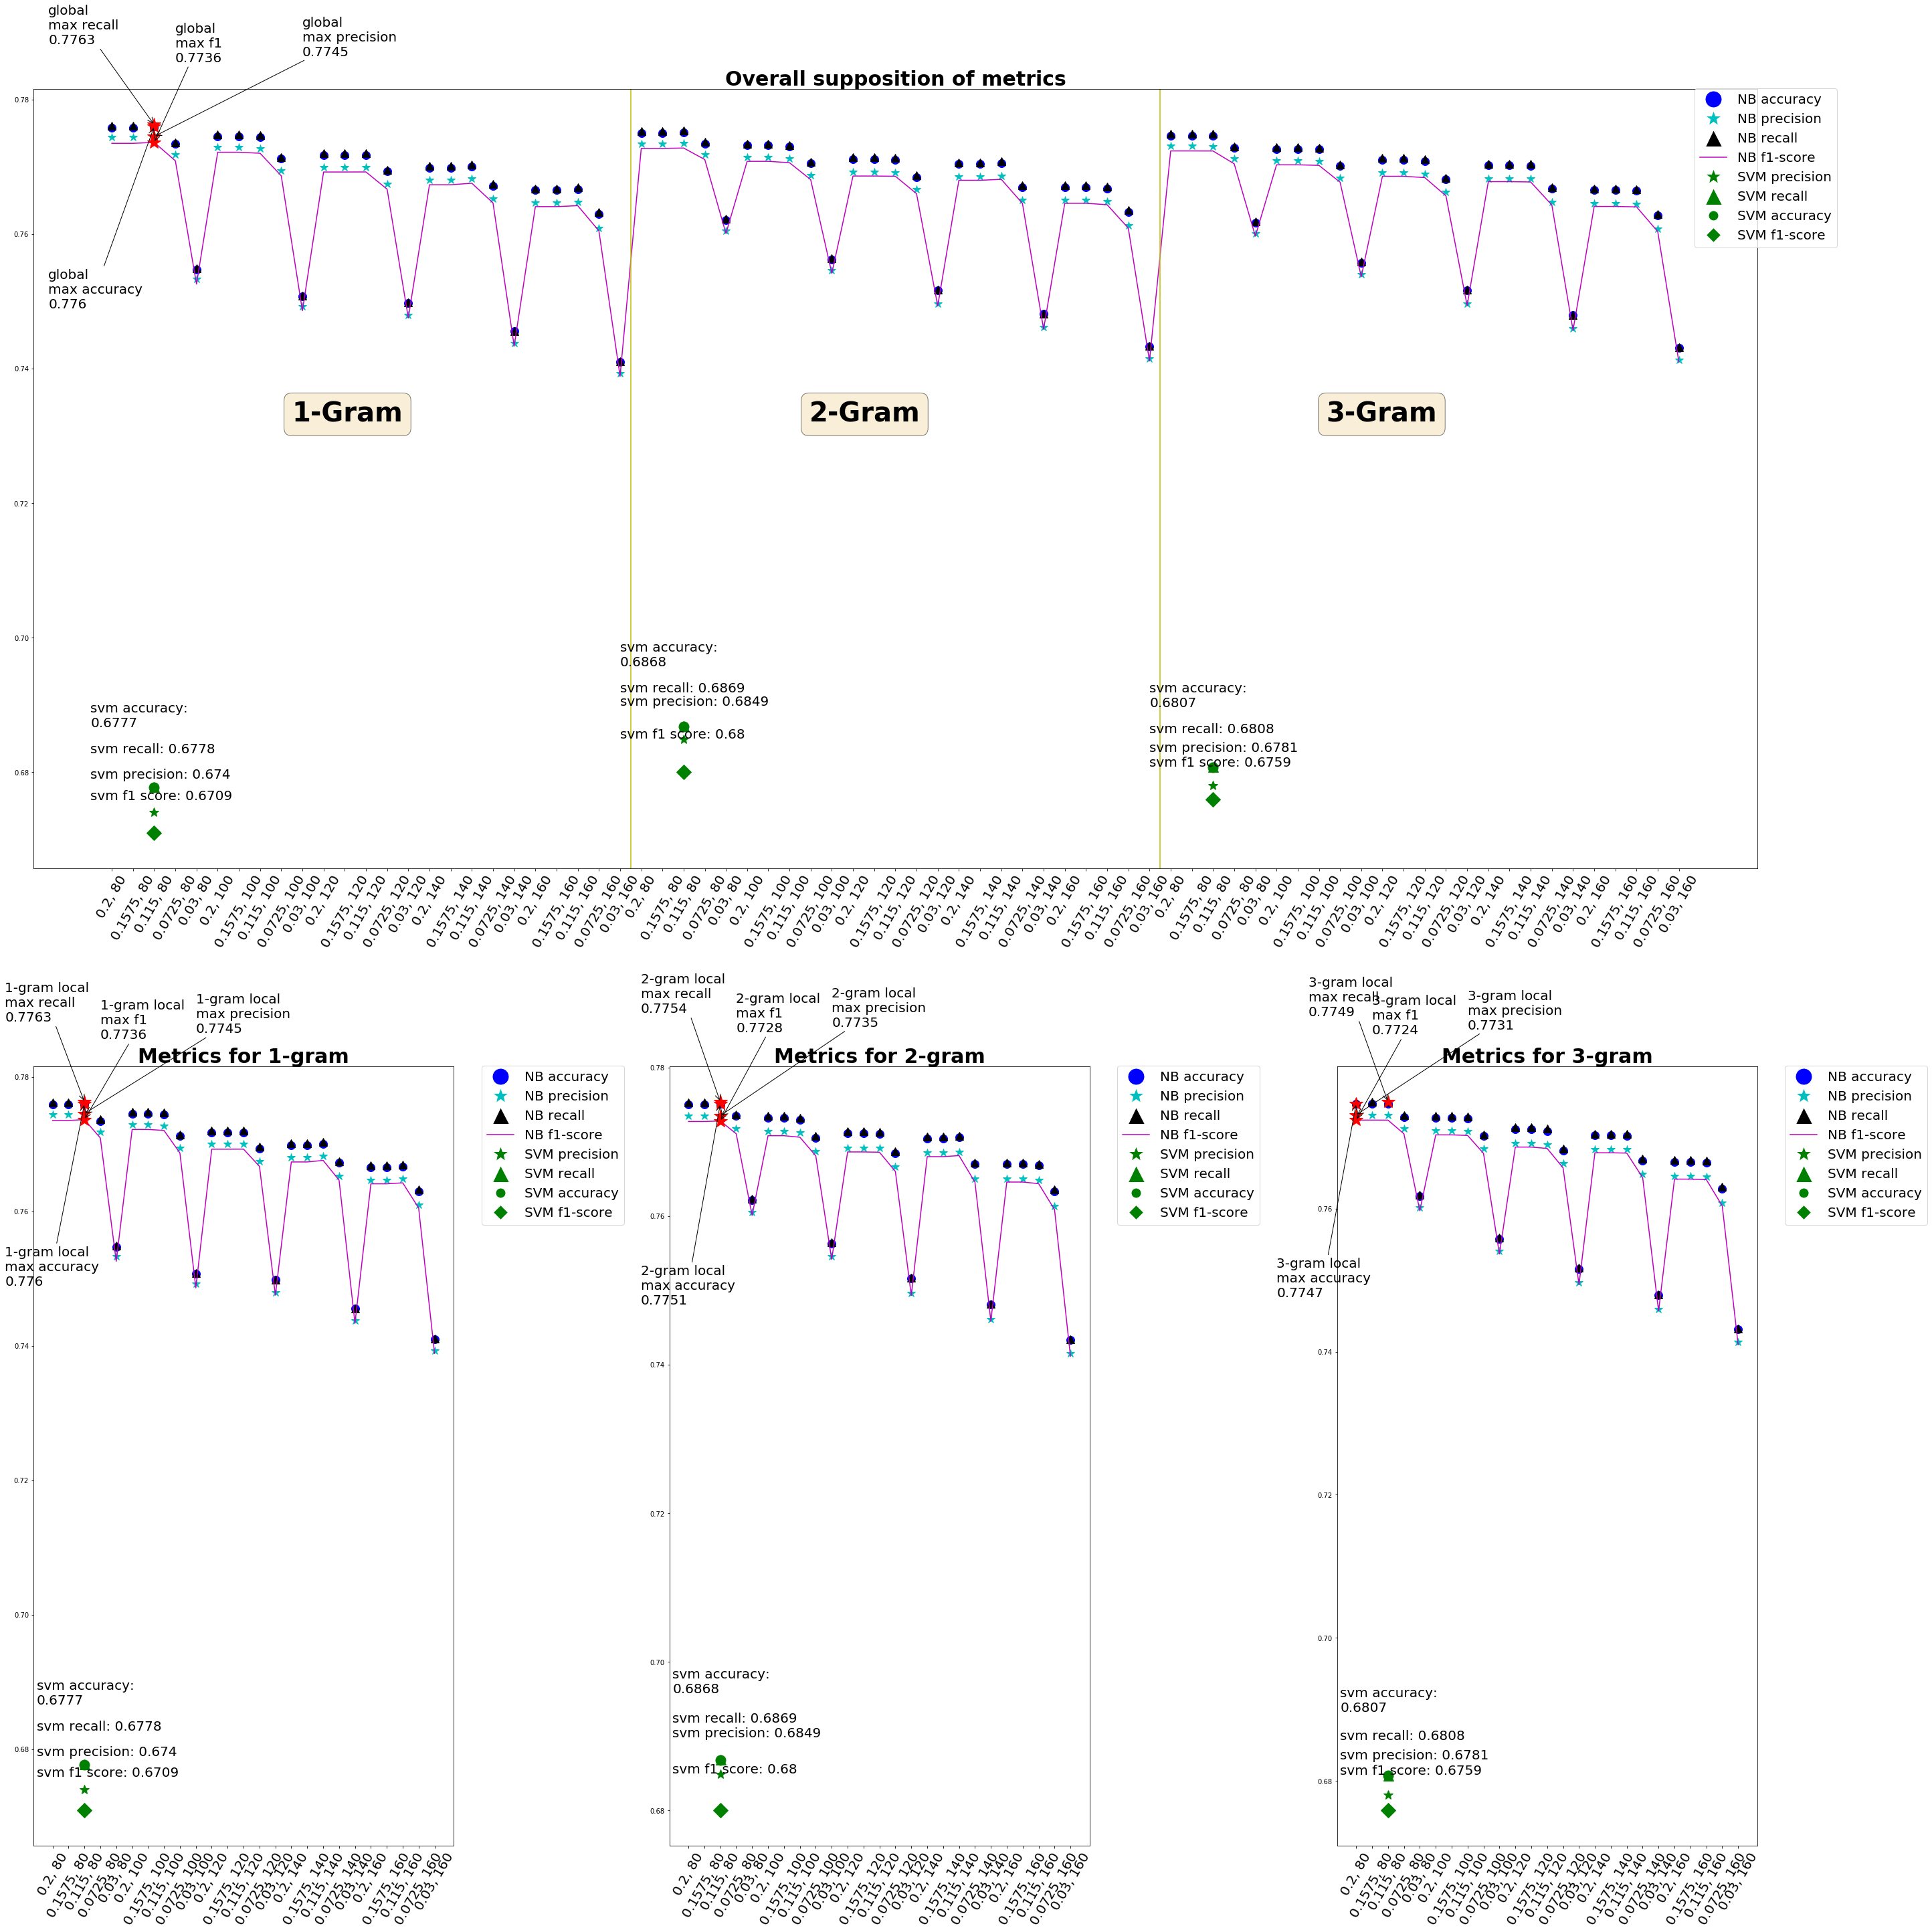

In [69]:

legend_data = ['accuracy','precision','recall','f1-score']
fig = plt.figure(figsize = (40,40),constrained_layout=True)
gs = fig.add_gridspec(2, 3)

ax1 = fig.add_subplot(gs[0, :])
plot_basic(ax1,'Overall supposition of metrics',plot_parameters)
draw_text_boxes(ax1)
ax1.axvline(x=24.5,c = 'y')
ax1.axvline(x=49.5,c = 'y')
draw_max(ax1,[GLOBAL_MAX_F1, GLOBAL_MAX_PREC, GLOBAL_MAX_RECALL,GLOBAL_MAX_ACC],
        np_f1, np_precisions, np_recalls, np_accuracy)
plot_svm(ax1, GLOBAL_MAX_F1, np_recalls_svm, np_f1_svm,
            np_precisions_svm,
            np_accuracy_svm)

ax2 = fig.add_subplot(gs[1, 0:1])
plot_basic(ax2,'Metrics for 1-gram',plot_parameters,from_ = 0,to_ = N_TRIALS**2)
draw_max(ax2,[max_1gram_f1, max_1gram_prec, max_1gram_recall,max_1gram_acc],
        np_f1[:N_TRIALS**2], np_precisions[:N_TRIALS**2], np_recalls[:N_TRIALS**2], np_accuracy[:N_TRIALS**2],
        '1-gram local')
plot_svm(ax2, GLOBAL_MAX_F1, np_recalls_svm, np_f1_svm,
            np_precisions_svm,
            np_accuracy_svm,[True,False,False],True)

ax3 = fig.add_subplot(gs[1, 1:2])
ax3.set_title('Metrics for 2-gram',fontsize = 30,weight='bold')
plot_basic(ax3,'Metrics for 2-gram',plot_parameters,from_ = N_TRIALS**2,to_ = (N_TRIALS**2)*2)
draw_max(ax3,[max_2gram_f1, max_2gram_prec, max_2gram_recall,max_2gram_acc],
        np_f1[N_TRIALS**2:(N_TRIALS**2)*2], np_precisions[N_TRIALS**2:(N_TRIALS**2)*2], np_recalls[N_TRIALS**2:(N_TRIALS**2)*2], np_accuracy[N_TRIALS**2:(N_TRIALS**2)*2],
        '2-gram local')
plot_svm(ax3, GLOBAL_MAX_F1, np_recalls_svm, np_f1_svm,
            np_precisions_svm,
            np_accuracy_svm,[False,True,False],True)
ax4 = fig.add_subplot(gs[1, 2:])
ax4.set_title('Metrics for 3-gram',fontsize = 30,weight='bold')
plot_basic(ax4,'Metrics for 3-gram',plot_parameters,from_ = (N_TRIALS**2)*2,to_ = len(plot_parameters))
draw_max(ax4,[max_3gram_f1, max_3gram_prec, max_3gram_recall,max_3gram_acc],
        np_f1[(N_TRIALS**2)*2:], np_precisions[(N_TRIALS**2)*2:], np_recalls[(N_TRIALS**2)*2:], np_accuracy[(N_TRIALS**2)*2:],
        '3-gram local',True)
plot_svm(ax4, GLOBAL_MAX_F1, np_recalls_svm, np_f1_svm,
            np_precisions_svm,
            np_accuracy_svm,[False,False,True],True)
fig.savefig('balanced metrics comparison')

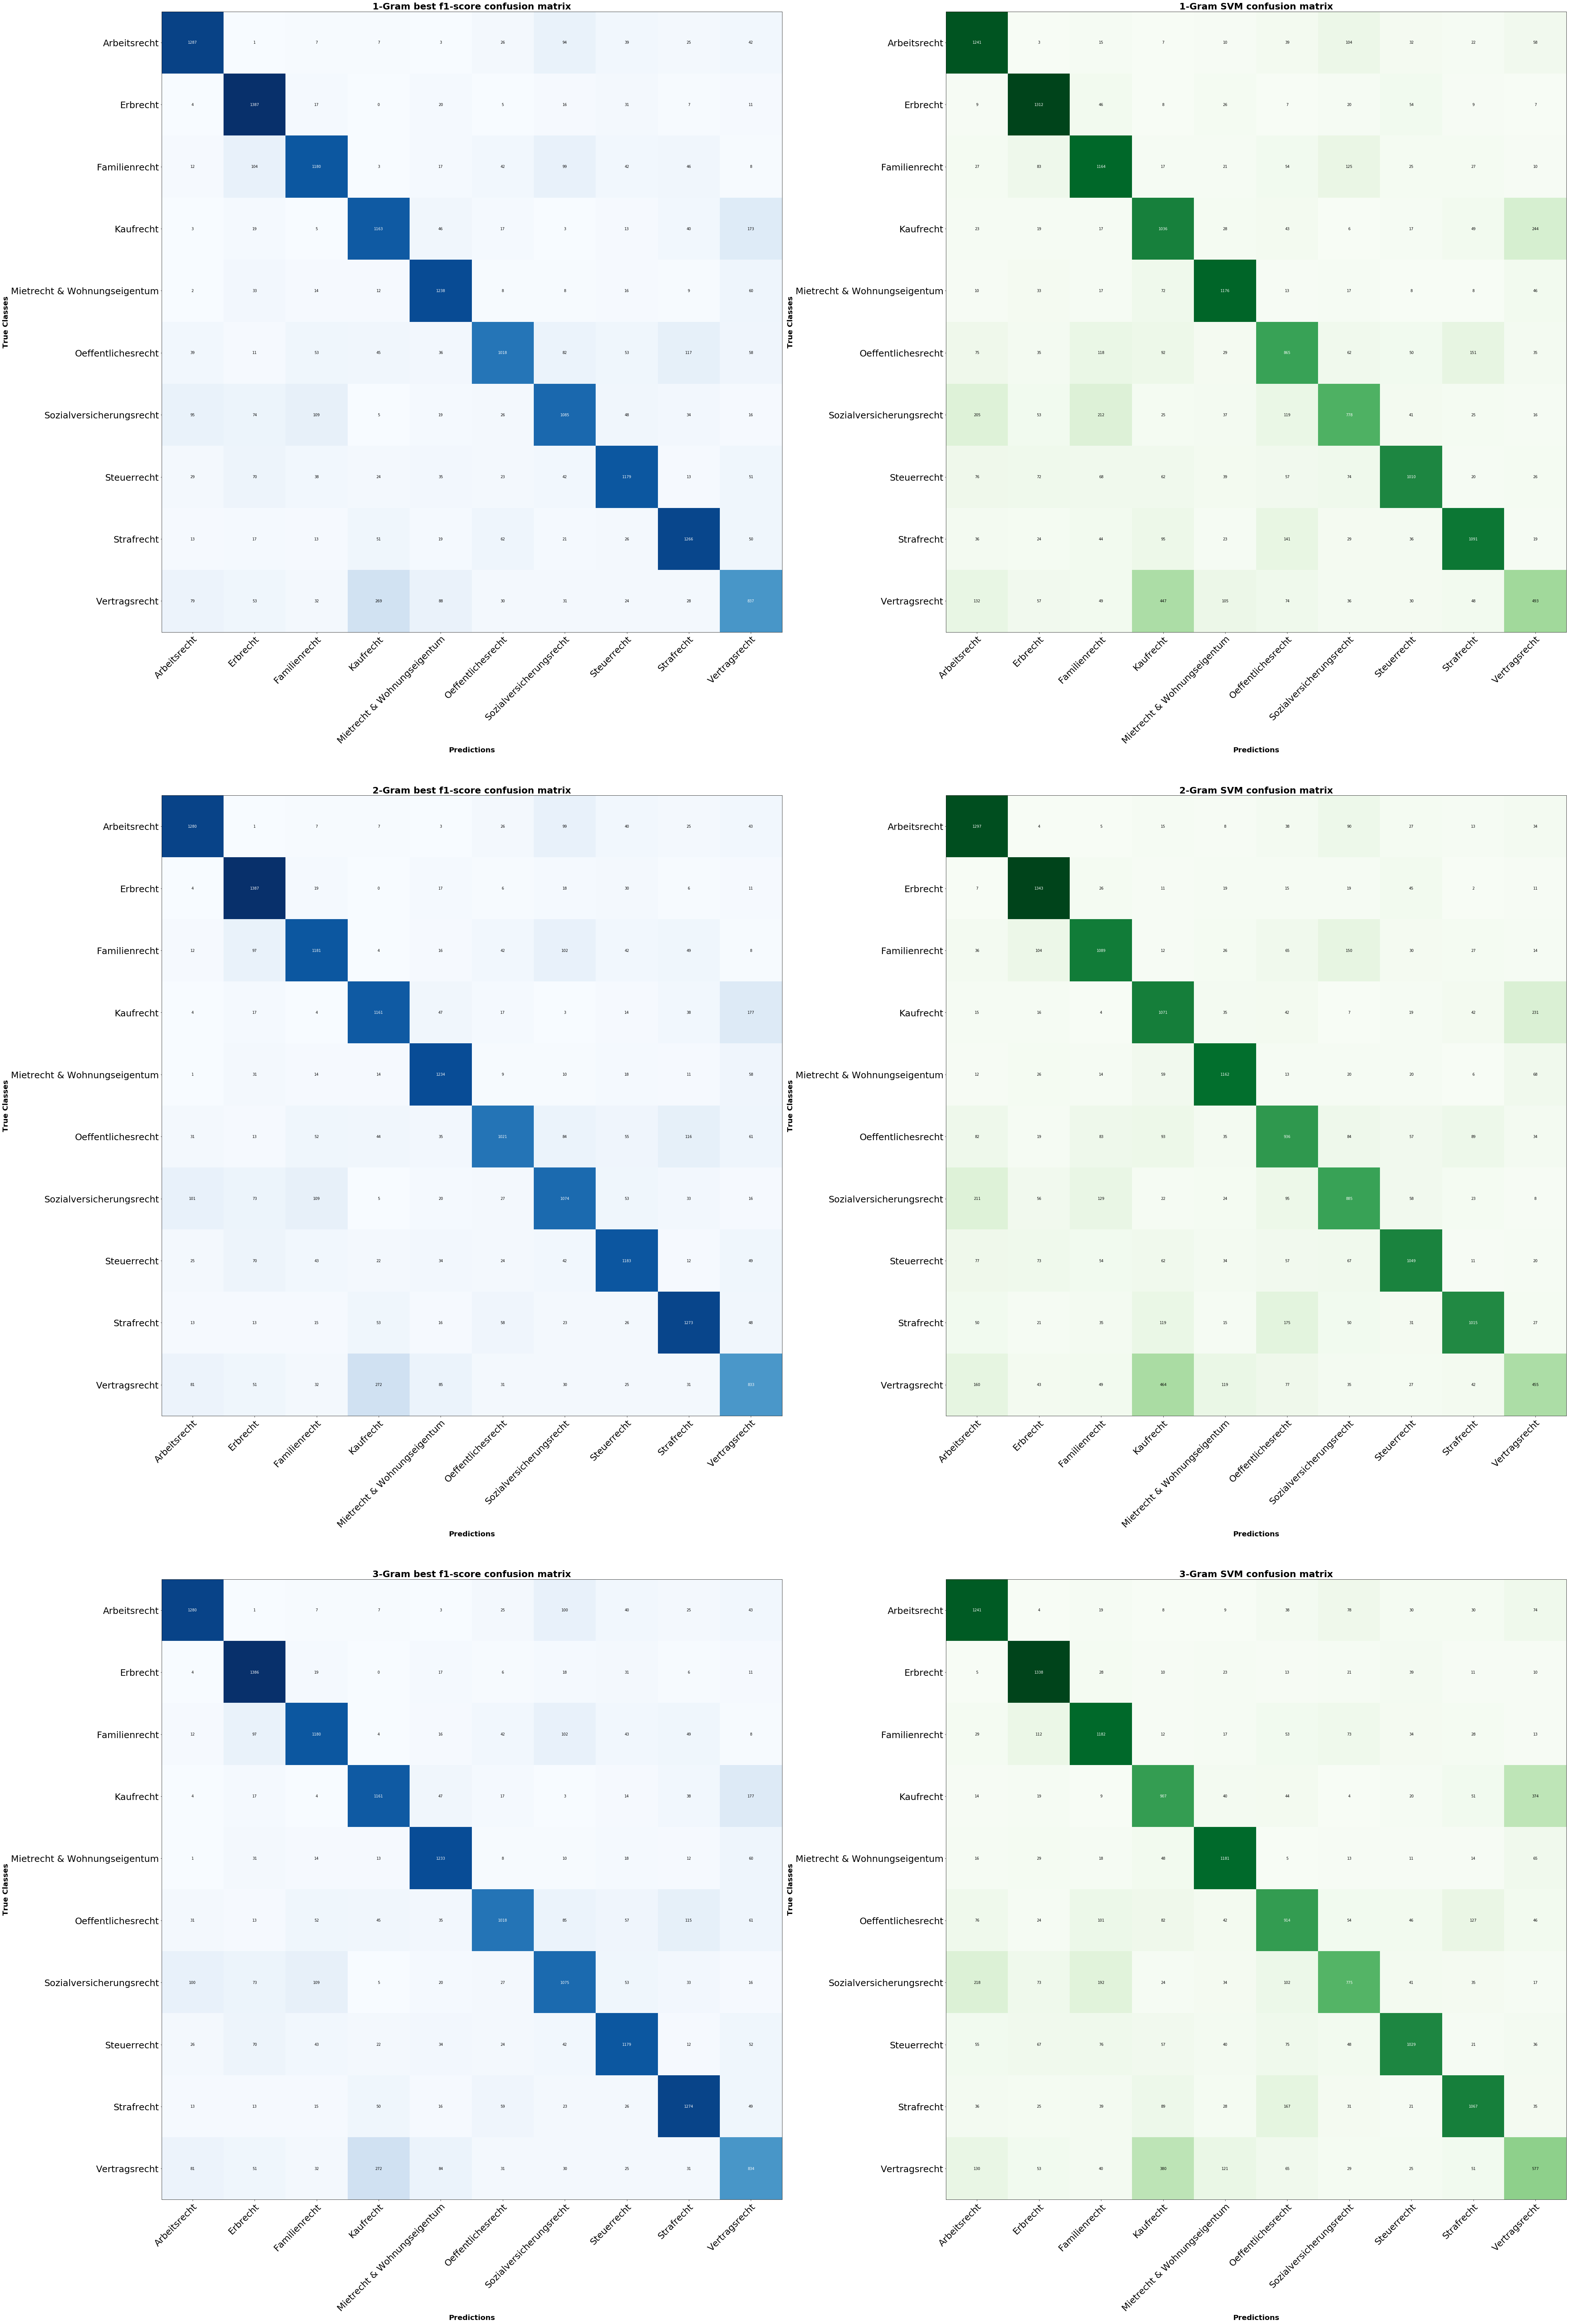

In [74]:
fig = plt.figure(figsize = (60,90))

ax = fig.subplots(3,2)

plot_confusion_matrix(ax[0,0],np_accuracy[max_1gram_f1,0],'1-Gram best f1-score confusion matrix')
plot_confusion_matrix(ax[1,0],np_accuracy[N_TRIALS**2+max_2gram_f1,0],'2-Gram best f1-score confusion matrix')
plot_confusion_matrix(ax[2,0],np_accuracy[(N_TRIALS**2)*2+max_3gram_f1,0],'3-Gram best f1-score confusion matrix')
plot_confusion_matrix(ax[0,1],np_accuracy_svm[0,0],'1-Gram SVM confusion matrix',cmap = plt.cm.Greens)
plot_confusion_matrix(ax[1,1],np_accuracy_svm[1,0],'2-Gram SVM confusion matrix',cmap = plt.cm.Greens)
plot_confusion_matrix(ax[2,1],np_accuracy_svm[2,0],'3-Gram SVM confusion matrix',cmap = plt.cm.Greens)
fig.savefig('balanced confision matrics comparison')

In [75]:
CLASS_DISTRIBUTION = np.array([np.where(y==i)[0].shape[0]/y.shape[0] for i in TOPICS])

In [76]:
def plot_metrics_classes(ax,recalls, f1, precisions, N,title,fc = (1,0.8,0.78,0.7)):
    ax.set_yticks(range(0,N_TOPICS))

    ax.set_yticklabels(encoder.classes_,fontsize = 15) 
    ax.barh(range(N_TOPICS), CLASS_DISTRIBUTION*5,fc = fc)
    ax.plot(recalls[N,0],range(N_TOPICS),'k^',markersize = 8)
    ax.plot(precisions[N,0],range(N_TOPICS),'c*',markersize=12)
    ax.plot(f1[N,0],range(N_TOPICS),'rD',markersize = 8)

    
    
    i=0.1
    for area in range(N_TOPICS):
        ax.text(0.006,i,s = 'f1: {},prc: {}, rcl: {}'.format(round(f1[0,0][area],2),
                                                         round(precisions[0,0][area],2),
                                                         round(recalls[0,0][area],2)),fontsize = 15)
        i+=1

    ax.set_ylim(-0.6,N_TOPICS-0.5)
    ax.set_title(title,fontsize = 20,weight = 'bold')
    legend_elements = [Line2D([0], [0], color = 'w',marker='*', markerfacecolor='c', label='precision',markersize=25),
                      Line2D([0], [0], color = 'w',marker='^', markerfacecolor='k', label='recall',markersize=25),
                      Line2D([0], [0], color='w',marker='D',markerfacecolor='r',label='f1-score',markersize = 19),
                      Line2D([0], [0], color='w',label='relative class weight',linewidth=15)]
    legend_elements[-1].set_color(color=fc)
    ax.legend(handles = legend_elements,bbox_to_anchor=(1.05, 1.01),prop={'size':20})
    ax.invert_yaxis()

In [77]:
parameters[GLOBAL_MAX_F1]

{'max_df': 0.115, 'min_df': 80, 'ngram_range': (1, 1)}

### Plot metrics per class

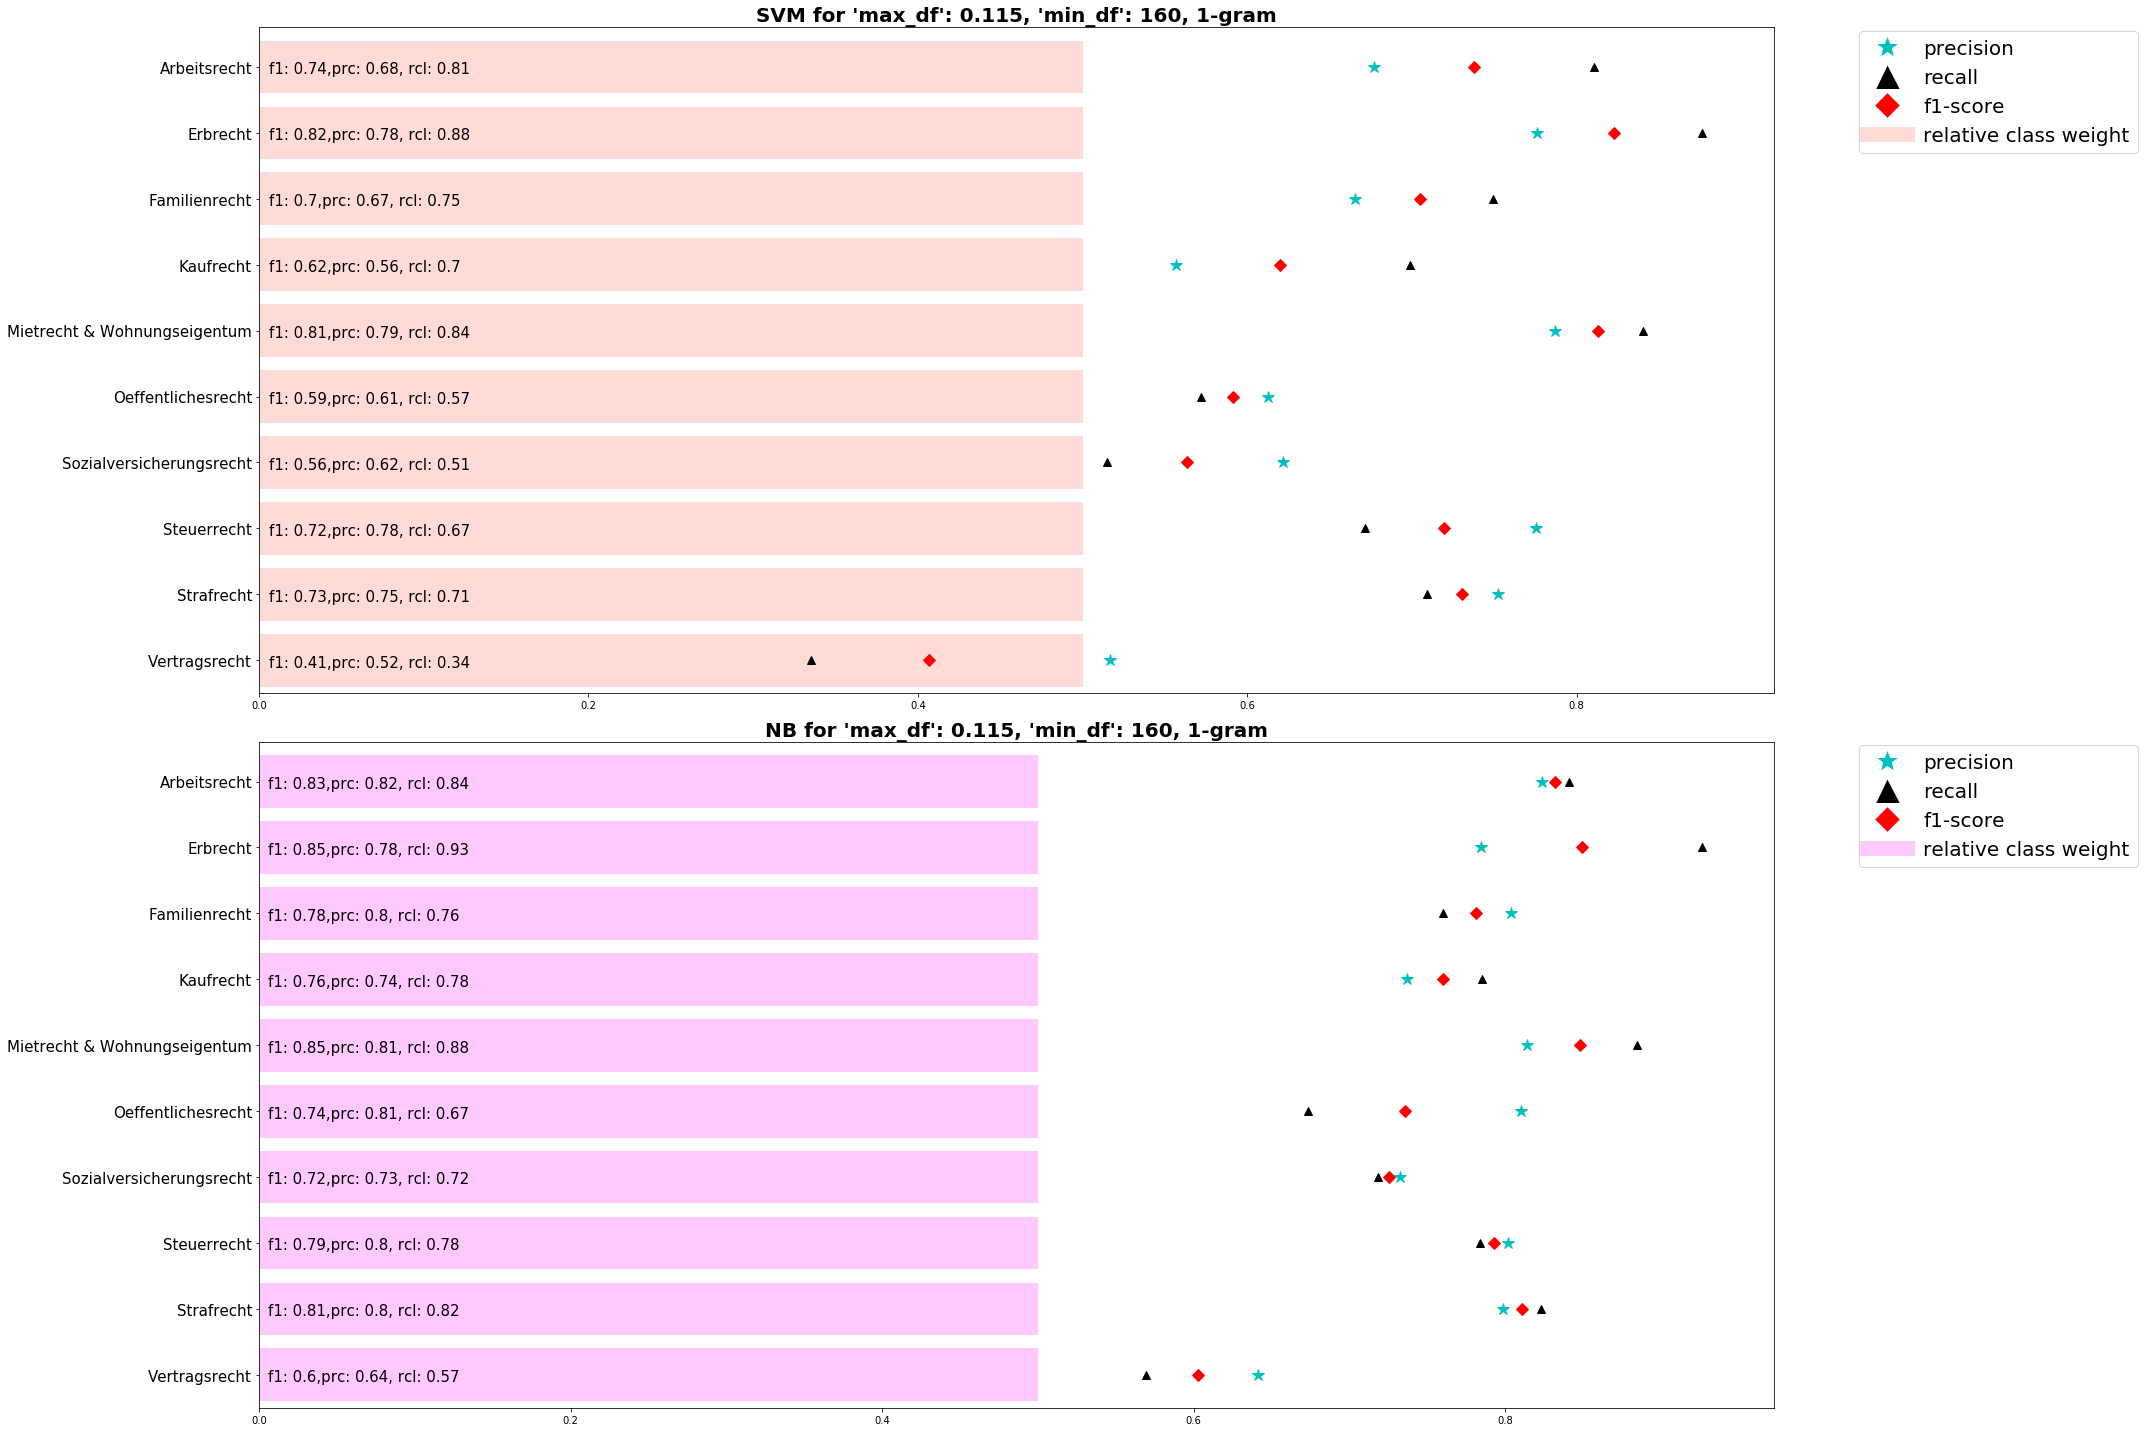

In [78]:
fig = plt.figure(figsize=(30,20))
ax = fig.subplots(2,1)
plot_metrics_classes(ax[0],np_recalls_svm,np_f1_svm,np_precisions_svm,0,'SVM for \'max_df\': 0.115, \'min_df\': 160, 1-gram')
plot_metrics_classes(ax[1],np_recalls,np_f1,np_precisions,GLOBAL_MAX_F1,'NB for \'max_df\': 0.115, \'min_df\': 160, 1-gram',fc = (1,0.7,1,0.7))
fig.tight_layout()
fig.savefig('balanced_class_comparison')